DS5230
Devin Quinn

Final Project
"Fourth and Long: Unsupervised Machine Learning for Football Decisions"

In [124]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import collections
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

Import play by play data for the 2022 Season from NFL Fast_R

In [155]:
pbp_py = nfl.import_pbp_data([2022])

2022 done.
Downcasting floats.


Next lines of hope help to understand how the data is structured

In [3]:
pbp_py.columns

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'players_on_play',
       'offense_players', 'defense_players', 'n_offense', 'n_defense'],
      dtype='object', length=384)

In [5]:
pbp_py['fourth_down_converted'].value_counts()

fourth_down_converted
0.0    47544
1.0      397
Name: count, dtype: int64

In [6]:
pbp_py['fourth_down_failed'].value_counts()

fourth_down_failed
0.0    47566
1.0      375
Name: count, dtype: int64

Create a data frame using where there are only converted 4th Downs

In [7]:
for_conv = pbp_py[pbp_py['fourth_down_converted'] == 1.0]

Visualize the relationship between yards to go and 
where the ball is on the field and how they 
relate to completed 4th downs. 

<Axes: xlabel='yardline_100', ylabel='ydstogo'>

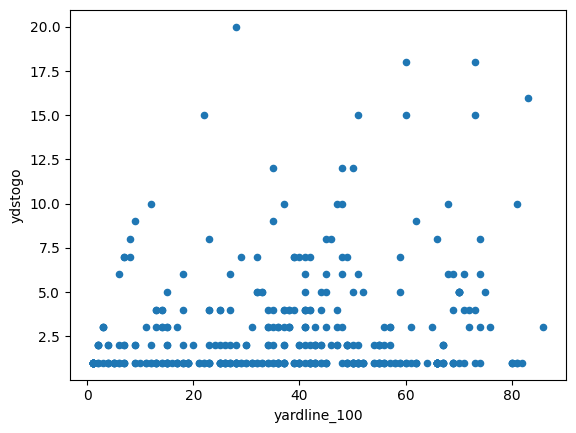

In [8]:
for_conv.plot.scatter(x='yardline_100', y='ydstogo')

Create a dataframe from completed 4th downs and include the
position of the ball on the field, the yards to go to achieve a 1st down,
and the yards gained by the play.

In [9]:
for_yds = for_conv[['yardline_100', 'ydstogo', 'yards_gained']].copy()

In [10]:
for_yds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 145 to 50087
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yardline_100  397 non-null    float32
 1   ydstogo       397 non-null    float32
 2   yards_gained  397 non-null    float32
dtypes: float32(3)
memory usage: 7.8 KB


In [11]:
for_yds.head()

,yardline_100,ydstogo,yards_gained
145,28.0,1.0,7.0
150,14.0,3.0,4.0
170,22.0,15.0,19.0
235,28.0,2.0,3.0
315,67.0,1.0,1.0


Drop na values for better processing.

In [12]:
for_yds = for_yds.dropna()

The following code prepares the data for K-means clustering

In [13]:
scaled_df = StandardScaler().fit_transform(for_yds)

In [14]:
scaled_df[:5]

array([[-0.43204674, -0.58115697, -0.17689352],
       [-1.0791273 ,  0.08759467, -0.48490548],
       [-0.709367  ,  4.1001043 ,  1.0551543 ],
       [-0.43204674, -0.24678114, -0.58757615],
       [ 1.3705348 , -0.58115697, -0.79291743]], dtype=float32)

In [31]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

In [16]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

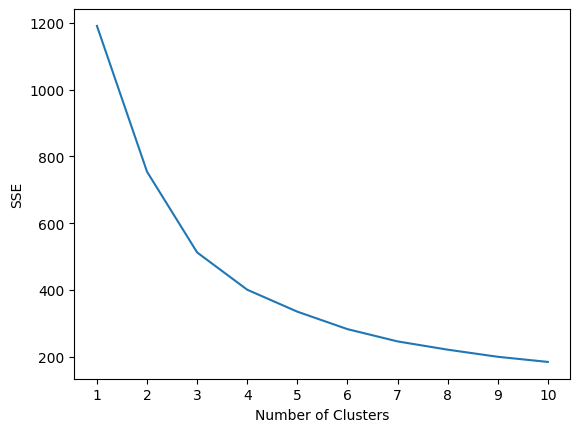

In [17]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The graph above identifies how many clusters there need to be in k-means, 3.
The following code does k-means.

In [18]:
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)

In [19]:
kmeans.fit(scaled_df)

KMeans(init='random', n_clusters=3, n_init=10, random_state=1)

In [20]:
kmeans.labels_

array([2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 1, 0, 0, 1, 0,
       2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 0, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0,
       1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0,
       0, 2, 0, 1, 0, 2, 1, 0, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 1,
       0, 0, 1, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0,
       0, 2, 0, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1,
       0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0,
       2, 1, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 1, 2, 1, 0, 0, 2, 2,
       2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 2, 1, 0, 0, 0, 1, 2,
       2, 1, 0, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 0, 1, 0, 1, 0, 2, 1,
       0, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 0, 1,

Create and extra column in the data frame to identify the cluster.

In [21]:
for_yds['cluster'] = kmeans.labels_

In [22]:
for_yds

,yardline_100,ydstogo,yards_gained,cluster
145,28.0,1.0,7.0,2
150,14.0,3.0,4.0,2
170,22.0,15.0,19.0,1
235,28.0,2.0,3.0,2
315,67.0,1.0,1.0,0
...,...,...,...,...
49822,35.0,3.0,29.0,1
49871,66.0,1.0,2.0,0
49965,23.0,2.0,6.0,2
50033,44.0,5.0,28.0,1


Two dimensional plot of the clusters.

<Axes: xlabel='yardline_100', ylabel='ydstogo'>

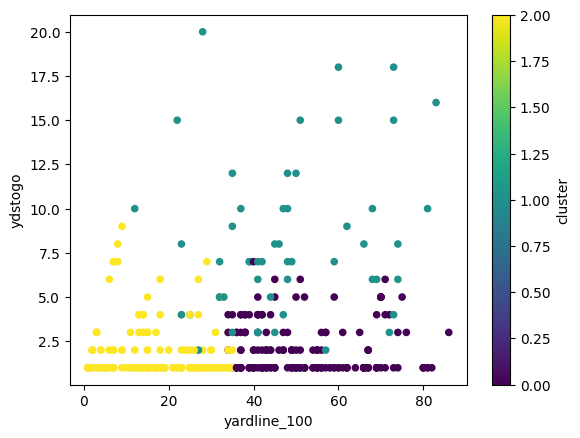

In [23]:
for_yds.plot.scatter(x='yardline_100', y='ydstogo', c='cluster', colormap='viridis')

In [24]:
import plotly.express as px

Three dimensional plot of the successful fourth down completions.

In [25]:
fig = px.scatter_3d(for_yds, x='yardline_100', y='ydstogo', z='yards_gained',
                    color='cluster')

fig.show()

The following code does the same but for failed conversion attempts.

In [26]:
for_fail = pbp_py[pbp_py['fourth_down_failed'] == 1.0]

In [28]:
fail_yds = for_fail[['yardline_100', 'ydstogo', 'yards_gained']].copy()

In [29]:
fail_yds.head()

,yardline_100,ydstogo,yards_gained
154,6.0,6.0,0.0
338,16.0,14.0,0.0
355,36.0,3.0,0.0
556,7.0,1.0,0.0
621,1.0,1.0,-1.0


In [30]:
fail_yds = fail_yds.dropna()
scaled_fail = StandardScaler().fit_transform(fail_yds)
scaled_fail[:5]

array([[-1.4173497 ,  0.13856024,  0.1084865 ],
       [-0.96508104,  1.6556433 ,  0.1084865 ],
       [-0.0605437 , -0.43034586,  0.1084865 ],
       [-1.3721229 , -0.8096166 ,  0.1084865 ],
       [-1.643484  , -0.8096166 , -0.16272976]], dtype=float32)

In [32]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_fail)
    sse.append(kmeans.inertia_)

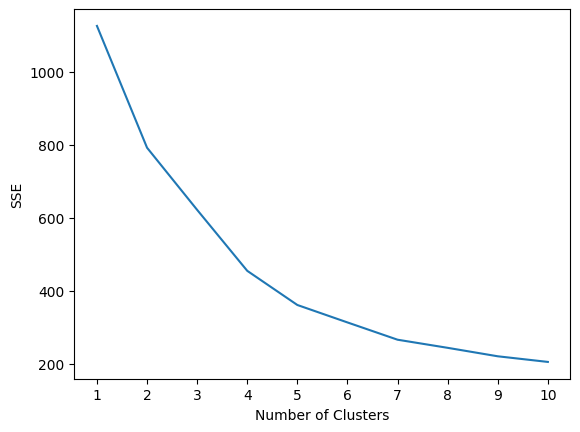

In [33]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [35]:
kmeans = KMeans(init="random", n_clusters=4, n_init=10, random_state=1)

In [36]:
kmeans.fit(scaled_fail)

KMeans(init='random', n_clusters=4, n_init=10, random_state=1)

In [37]:
kmeans.labels_

array([2, 0, 3, 2, 2, 2, 2, 2, 2, 3, 2, 1, 3, 3, 3, 2, 3, 0, 3, 0, 0, 2,
       3, 3, 1, 2, 0, 0, 2, 2, 3, 2, 3, 3, 2, 0, 3, 2, 3, 1, 0, 3, 2, 3,
       2, 1, 2, 3, 3, 3, 3, 3, 0, 2, 1, 2, 3, 2, 3, 3, 2, 2, 0, 3, 3, 2,
       3, 3, 2, 2, 3, 3, 1, 2, 3, 1, 0, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 1,
       3, 2, 3, 2, 3, 3, 0, 2, 2, 3, 3, 3, 3, 3, 2, 2, 0, 2, 2, 0, 1, 1,
       0, 3, 2, 2, 1, 1, 0, 2, 3, 0, 3, 2, 3, 3, 3, 2, 3, 3, 0, 3, 2, 2,
       0, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 0, 2, 3, 0, 2, 2, 3, 3, 2, 0, 2,
       3, 0, 3, 2, 3, 3, 3, 2, 3, 2, 3, 0, 2, 2, 3, 3, 2, 3, 3, 1, 2, 3,
       0, 3, 2, 0, 3, 3, 3, 0, 0, 1, 1, 3, 2, 1, 0, 3, 2, 1, 3, 2, 3, 2,
       2, 2, 3, 1, 0, 2, 3, 3, 3, 1, 0, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 0,
       3, 3, 3, 0, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2,
       2, 0, 0, 3, 2, 2, 2, 3, 3, 2, 2, 3, 0, 3, 2, 3, 3, 3, 3, 1, 0, 0,
       3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 0, 3, 2, 3, 3, 0, 3, 2, 3, 3, 3, 3,
       2, 3, 2, 0, 0, 2, 3, 2, 3, 3, 3, 3, 0, 2, 3,

In [38]:
fail_yds['cluster'] = kmeans.labels_

In [39]:
fail_yds

,yardline_100,ydstogo,yards_gained,cluster
154,6.0,6.0,0.0,2
338,16.0,14.0,0.0,0
355,36.0,3.0,0.0,3
556,7.0,1.0,0.0,2
621,1.0,1.0,-1.0,2
...,...,...,...,...
49091,16.0,6.0,0.0,2
49484,40.0,8.0,-8.0,1
49616,64.0,8.0,0.0,3
49946,53.0,2.0,-4.0,3


In [40]:
fig = px.scatter_3d(fail_yds, x='yardline_100', y='ydstogo', z='yards_gained',
                    color='cluster')

fig.show()

In [126]:
converted = pbp_py[pbp_py['fourth_down_converted'] == 1.0]

In [127]:
converted['offense_formation'].head()

145    SINGLEBACK
150       SHOTGUN
170       SHOTGUN
235         EMPTY
315       SHOTGUN
Name: offense_formation, dtype: object

The following code builds a data frame with string values that 
are pertinent to fourth down attempts for association rule mining. 

In [128]:
conv_yds = converted[['posteam_type', 'game_half',
                      'play_type', 'game_stadium', 'offense_formation']].copy()

In [129]:
conv_yds.head()

,posteam_type,game_half,play_type,game_stadium,offense_formation
145,home,Half2,pass,MetLife Stadium,SINGLEBACK
150,home,Half2,pass,MetLife Stadium,SHOTGUN
170,home,Half2,pass,MetLife Stadium,SHOTGUN
235,home,Half1,pass,SoFi Stadium,EMPTY
315,home,Half2,run,SoFi Stadium,SHOTGUN


In [130]:
conv_yds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 145 to 50087
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   posteam_type       397 non-null    object
 1   game_half          397 non-null    object
 2   play_type          397 non-null    object
 3   game_stadium       397 non-null    object
 4   offense_formation  383 non-null    object
dtypes: object(5)
memory usage: 18.6+ KB


In [131]:
conv_yds = conv_yds.dropna()

In [132]:
arr = conv_yds.values.tolist()

In [133]:
arr

[['home', 'Half2', 'pass', 'MetLife Stadium', 'SINGLEBACK'],
 ['home', 'Half2', 'pass', 'MetLife Stadium', 'SHOTGUN'],
 ['home', 'Half2', 'pass', 'MetLife Stadium', 'SHOTGUN'],
 ['home', 'Half1', 'pass', 'SoFi Stadium', 'EMPTY'],
 ['home', 'Half2', 'run', 'SoFi Stadium', 'SHOTGUN'],
 ['away', 'Half2', 'run', 'Bank of America Stadium', 'I_FORM'],
 ['home', 'Half1', 'pass', 'U.S. Bank Stadium', 'SINGLEBACK'],
 ['away', 'Half1', 'pass', 'State Farm Stadium', 'SHOTGUN'],
 ['home', 'Half2', 'pass', 'State Farm Stadium', 'SHOTGUN'],
 ['home', 'Half2', 'pass', 'State Farm Stadium', 'SHOTGUN'],
 ['home', 'Half2', 'pass', 'State Farm Stadium', 'SHOTGUN'],
 ['away', 'Half2', 'pass', 'SoFi Stadium', 'SHOTGUN'],
 ['home', 'Half1', 'pass', 'Hard Rock Stadium', 'SHOTGUN'],
 ['away', 'Half2', 'run', 'Nissan Stadium', 'I_FORM'],
 ['away', 'Half1', 'run', 'Ford Field', 'SHOTGUN'],
 ['home', 'Half1', 'run', 'Ford Field', 'I_FORM'],
 ['away', 'Half2', 'run', 'Ford Field', 'I_FORM'],
 ['home', 'Half1', 'r

In [134]:
te = TransactionEncoder()
te_arr = te.fit_transform(arr)
te_arr

array([[False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True, False,  True]])

In [135]:
te.columns_

['AT&T Stadium',
 'Acrisure Stadium',
 'Allegiant Stadium',
 'Allianz Arena',
 'Bank of America Stadium',
 'EMPTY',
 'Empower Field at Mile High',
 'FedExField',
 'FirstEnergy Stadium',
 'Ford Field',
 'GEHA Field at Arrowhead Stadium',
 'Gillette Stadium',
 'Half1',
 'Half2',
 'Hard Rock Stadium',
 'I_FORM',
 'JUMBO',
 'Lambeau Field',
 "Levi's Stadium",
 'Lincoln Financial Field',
 'Lucas Oil Stadium',
 'Lumen Field',
 'M&T Bank Stadium',
 'Mercedes-Benz Stadium',
 'Mercedes-Benz Superdome',
 'MetLife Stadium',
 'NRG Stadium',
 'New Era Field',
 'Nissan Stadium',
 'Overtime',
 'PISTOL',
 'Paycor Stadium',
 'Raymond James Stadium',
 'SHOTGUN',
 'SINGLEBACK',
 'SoFi Stadium',
 'Soldier Field',
 'State Farm Stadium',
 'TIAA Bank Stadium',
 'Tottenham Stadium',
 'U.S. Bank Stadium',
 'WILDCAT',
 'Wembley Stadium',
 'away',
 'home',
 'pass',
 'run']

In [136]:
conv_ap = pd.DataFrame(te_arr, columns=te.columns_)

In [137]:
conv_ap

,AT&T Stadium,Acrisure Stadium,Allegiant Stadium,Allianz Arena,Bank of America Stadium,EMPTY,Empower Field at Mile High,FedExField,FirstEnergy Stadium,Ford Field,...,State Farm Stadium,TIAA Bank Stadium,Tottenham Stadium,U.S. Bank Stadium,WILDCAT,Wembley Stadium,away,home,pass,run
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
379,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
380,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
381,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,True,False,True


In [140]:
conv_freq_items = fpgrowth(conv_ap, min_support=0.3, use_colnames=True)

In [141]:
conv_freq_items

,support,itemsets
0,0.626632,(Half2)
1,0.483029,(home)
2,0.480418,(pass)
3,0.459530,(SHOTGUN)
4,0.370757,(Half1)
5,0.519582,(run)
6,0.516971,(away)
7,0.326371,"(pass, Half2)"
8,0.344648,"(pass, SHOTGUN)"
9,0.323760,"(Half2, SHOTGUN)"


The following code mines association rules for 4th down conversions.

In [143]:
association_rules(conv_freq_items, metric='confidence', min_threshold=0.4)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(pass),(Half2),0.480418,0.626632,0.326371,0.679348,1.084126,0.025326,1.164402,0.149347
1,(Half2),(pass),0.626632,0.480418,0.326371,0.520833,1.084126,0.025326,1.084346,0.207832
2,(pass),(SHOTGUN),0.480418,0.459530,0.344648,0.717391,1.561141,0.123881,1.912432,0.691792
3,(SHOTGUN),(pass),0.459530,0.480418,0.344648,0.750000,1.561141,0.123881,2.078329,0.665056
4,(Half2),(SHOTGUN),0.626632,0.459530,0.323760,0.516667,1.124337,0.035804,1.118214,0.296188
5,(SHOTGUN),(Half2),0.459530,0.626632,0.323760,0.704545,1.124337,0.035804,1.263708,0.204613
6,(Half2),(run),0.626632,0.519582,0.300261,0.479167,0.922215,-0.025326,0.922402,-0.184276
7,(run),(Half2),0.519582,0.626632,0.300261,0.577889,0.922215,-0.025326,0.884527,-0.149347
8,(Half2),(away),0.626632,0.516971,0.342037,0.545833,1.055829,0.018086,1.063549,0.141622
9,(away),(Half2),0.516971,0.626632,0.342037,0.661616,1.055829,0.018086,1.103386,0.109470


The following code does association rule mining for failed fourth down attempts.

In [144]:
failed = pbp_py[pbp_py['fourth_down_failed'] == 1.0]

In [145]:
fail = failed[['posteam_type', 'game_half',
                      'play_type', 'game_stadium', 'offense_formation']].copy()

In [146]:
fail = fail.dropna()

In [147]:
farr = fail.values.tolist()

In [148]:
farr

[['home', 'Half2', 'pass', 'MetLife Stadium', 'SHOTGUN'],
 ['home', 'Half2', 'pass', 'SoFi Stadium', 'SHOTGUN'],
 ['away', 'Half1', 'pass', 'Bank of America Stadium', 'SHOTGUN'],
 ['home', 'Half1', 'run', 'Lumen Field', 'SINGLEBACK'],
 ['away', 'Half2', 'run', 'Lumen Field', 'SHOTGUN'],
 ['away', 'Half1', 'run', 'U.S. Bank Stadium', 'SHOTGUN'],
 ['away', 'Half2', 'pass', 'U.S. Bank Stadium', 'EMPTY'],
 ['away', 'Half1', 'run', 'NRG Stadium', 'WILDCAT'],
 ['away', 'Half1', 'pass', 'FedExField', 'SHOTGUN'],
 ['home', 'Half1', 'pass', 'State Farm Stadium', 'SHOTGUN'],
 ['home', 'Half1', 'run', 'SoFi Stadium', 'SINGLEBACK'],
 ['away', 'Half2', 'pass', 'SoFi Stadium', 'SHOTGUN'],
 ['away', 'Half2', 'pass', 'Hard Rock Stadium', 'SHOTGUN'],
 ['away', 'Half1', 'pass', 'Ford Field', 'SHOTGUN'],
 ['home', 'Half2', 'pass', 'Paycor Stadium', 'SHOTGUN'],
 ['home', 'Half2', 'pass', 'Paycor Stadium', 'SHOTGUN'],
 ['away', 'Half2', 'pass', 'Soldier Field', 'SHOTGUN'],
 ['away', 'Half2', 'pass', 'Soldi

In [149]:
tef = TransactionEncoder()
te_farr = tef.fit_transform(farr)
te_farr

array([[False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])

In [150]:
tef.columns_

['AT&T Stadium',
 'Acrisure Stadium',
 'Allegiant Stadium',
 'Azteca Stadium',
 'Bank of America Stadium',
 'EMPTY',
 'Empower Field at Mile High',
 'FedExField',
 'FirstEnergy Stadium',
 'Ford Field',
 'GEHA Field at Arrowhead Stadium',
 'Gillette Stadium',
 'Half1',
 'Half2',
 'Hard Rock Stadium',
 'I_FORM',
 'JUMBO',
 'Lambeau Field',
 "Levi's Stadium",
 'Lincoln Financial Field',
 'Lucas Oil Stadium',
 'Lumen Field',
 'M&T Bank Stadium',
 'Mercedes-Benz Stadium',
 'Mercedes-Benz Superdome',
 'MetLife Stadium',
 'NRG Stadium',
 'New Era Field',
 'Nissan Stadium',
 'Overtime',
 'PISTOL',
 'Paycor Stadium',
 'Raymond James Stadium',
 'SHOTGUN',
 'SINGLEBACK',
 'SoFi Stadium',
 'Soldier Field',
 'State Farm Stadium',
 'TIAA Bank Stadium',
 'Tottenham Stadium',
 'U.S. Bank Stadium',
 'WILDCAT',
 'Wembley Stadium',
 'away',
 'home',
 'pass',
 'run']

In [151]:
fail_ap = pd.DataFrame(te_farr, columns=tef.columns_)

In [152]:
fail_ap

,AT&T Stadium,Acrisure Stadium,Allegiant Stadium,Azteca Stadium,Bank of America Stadium,EMPTY,Empower Field at Mile High,FedExField,FirstEnergy Stadium,Ford Field,...,State Farm Stadium,TIAA Bank Stadium,Tottenham Stadium,U.S. Bank Stadium,WILDCAT,Wembley Stadium,away,home,pass,run
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
356,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
357,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
358,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [153]:
fail_freq_items = fpgrowth(fail_ap, min_support=0.4, use_colnames=True)

In [154]:
fail_freq_items

,support,itemsets
0,0.750000,(pass)
1,0.666667,(Half2)
2,0.594444,(SHOTGUN)
3,0.500000,(home)
4,0.500000,(away)
5,0.541667,"(pass, Half2)"
6,0.538889,"(pass, SHOTGUN)"
7,0.430556,"(Half2, SHOTGUN)"


The following code builds a graph to show frequency of completed field goals within a 

In [156]:
field_goals = pbp_py[['yardline_100', 'field_goal_result']].copy()

In [158]:
field_goals = field_goals.dropna()
field_goals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, 32 to 50143
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   yardline_100       1105 non-null   float32
 1   field_goal_result  1105 non-null   object 
dtypes: float32(1), object(1)
memory usage: 21.6+ KB


/tmp/ipykernel_29282/3396592623.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



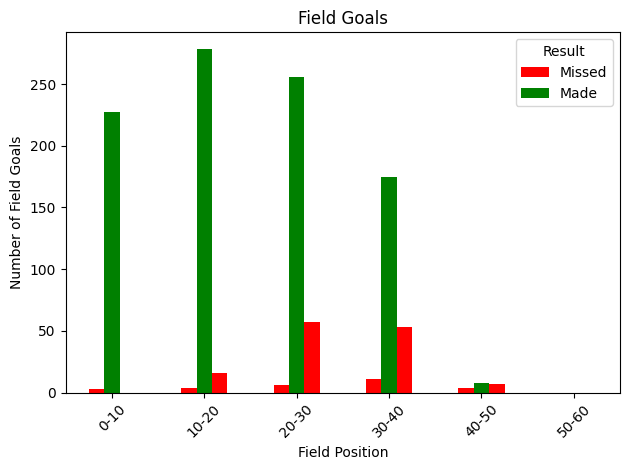

In [166]:
bins = [0,10,20,30,40,50,60]
field_goals['ranges'] = pd.cut(field_goals['yardline_100'], bins=bins, 
                               labels=[f'{i}-{i+10}' for i in range(0, 60, 10)])

made_counts = field_goals.groupby(['ranges', 'field_goal_result']).size().unstack(fill_value=0)
made_counts.plot(kind='bar', stacked=False, color=['red', 'green'])
plt.xlabel('Field Position')
plt.ylabel('Number of Field Goals')
plt.title('Field Goals')
plt.xticks(rotation=45)
plt.legend(title='Result', labels=['Missed', 'Made'], loc='upper right')
plt.tight_layout()
plt.show()